# SEDD Model Development Notebook

In [9]:
import pandas as pd 
import model_utils as mu
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses
import torch
import matplotlib.pyplot as plt

In [10]:
root_dir = 'data/tiles/processed'

In [11]:
df = pd.read_csv('csv_files/final_dataset_filtered.csv') 

In [12]:
#combining all species under the top 4 to 'other'
df['name'] = df['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')

In [13]:
#Printing the species count for future reference; this is the overall species count in the dataset
df['name'].value_counts()

name
Cacao            2021
Musacea          1495
Guaba             590
Otra variedad     428
Mango              89
Name: count, dtype: int64

## Loading and Visualizing Data

### Custom Transformer

In [14]:
transform = mu.RandomTransforms(
    horizontal_flip_prob=0.5,
    vertical_flip_prob=0.5,
    rotation_degrees=[0, 90, 180, 270]
)

### Splitting and Loading the Data

In [15]:
#small data for testing
df_small = df.sample(100)

In [18]:
#splitting the dataset into train and test
train_df, test_df, val_df = mu.split_data_SEDD(df_small)

Training set size: 69
Validation set size: 18
Testing set size: 13


In [63]:
train_data = mu.TreeCrownDataset(train_df, root_dir, transform=transform)

In [64]:
# Create an iterator from the dataset
data_iter = iter(train_data)

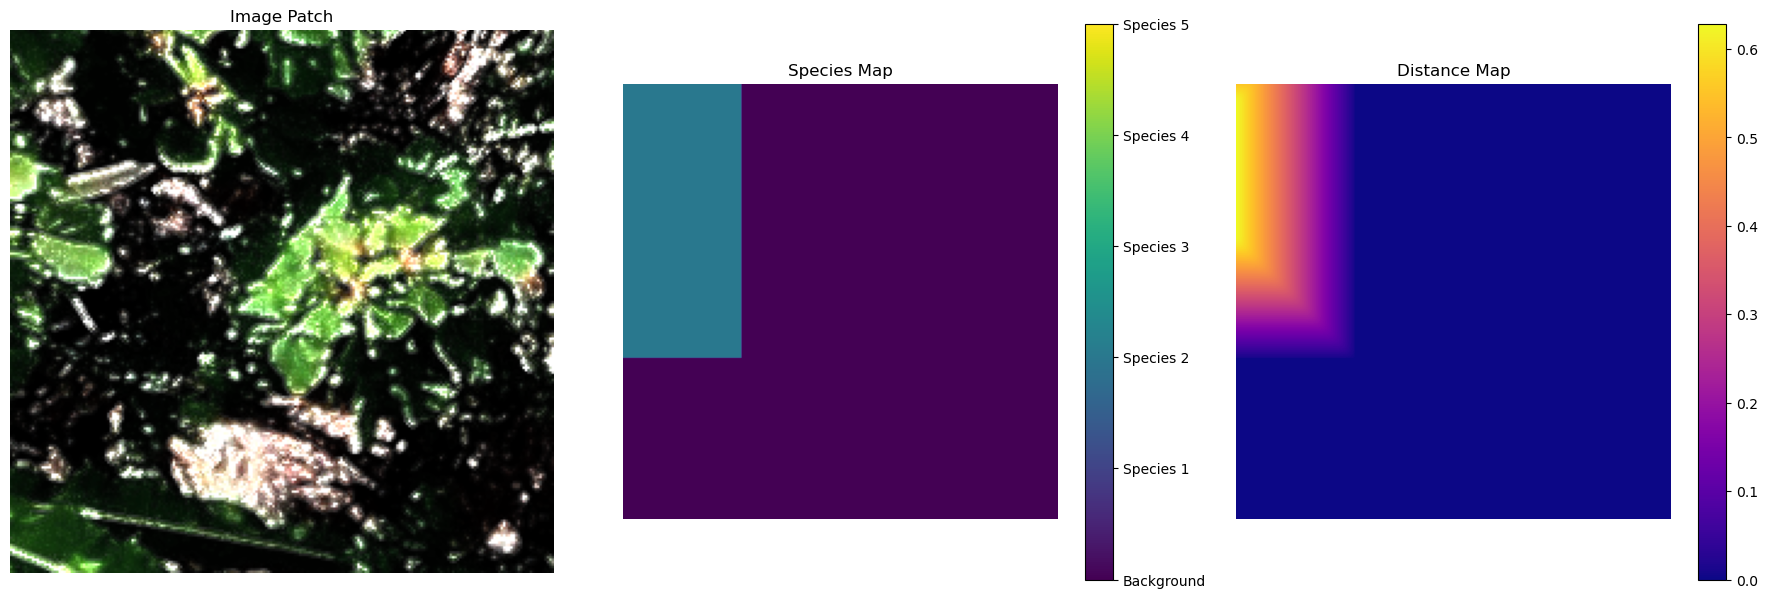

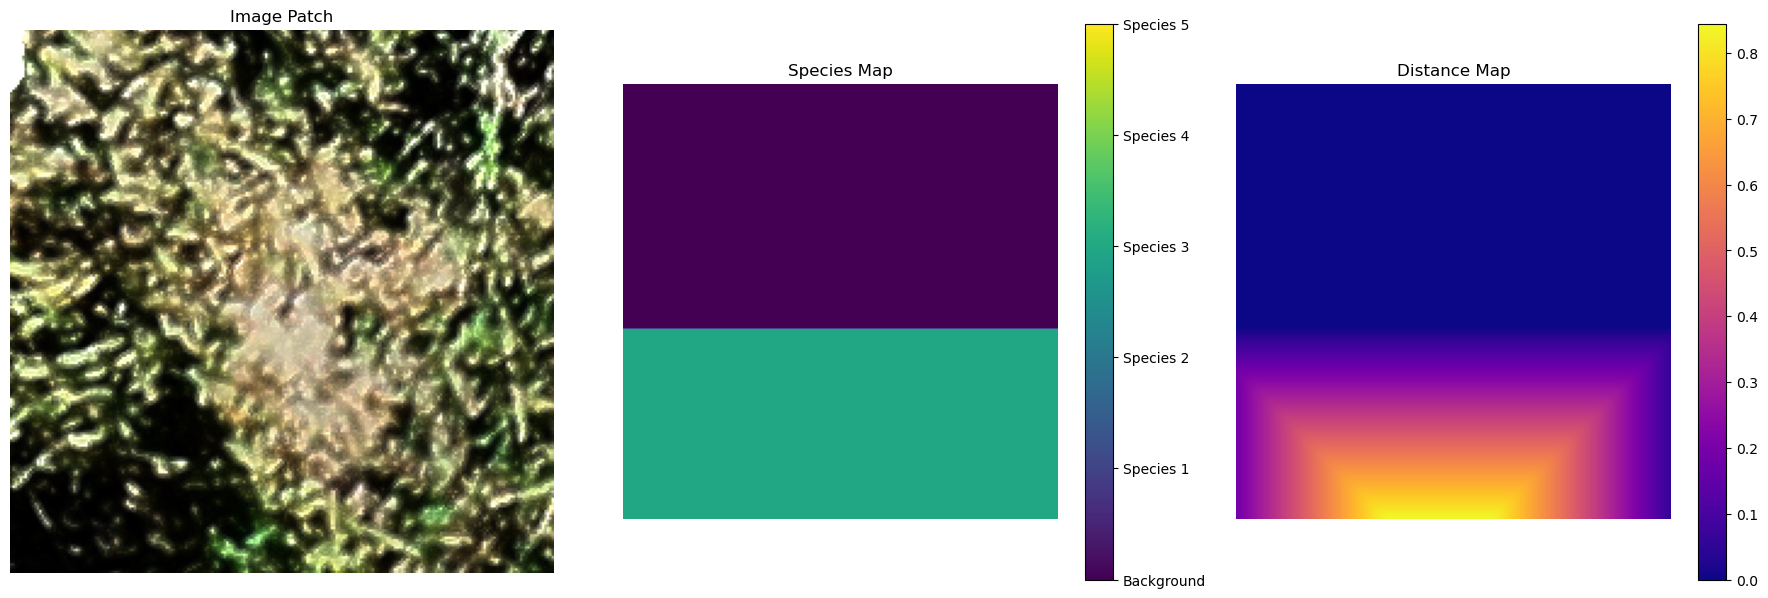

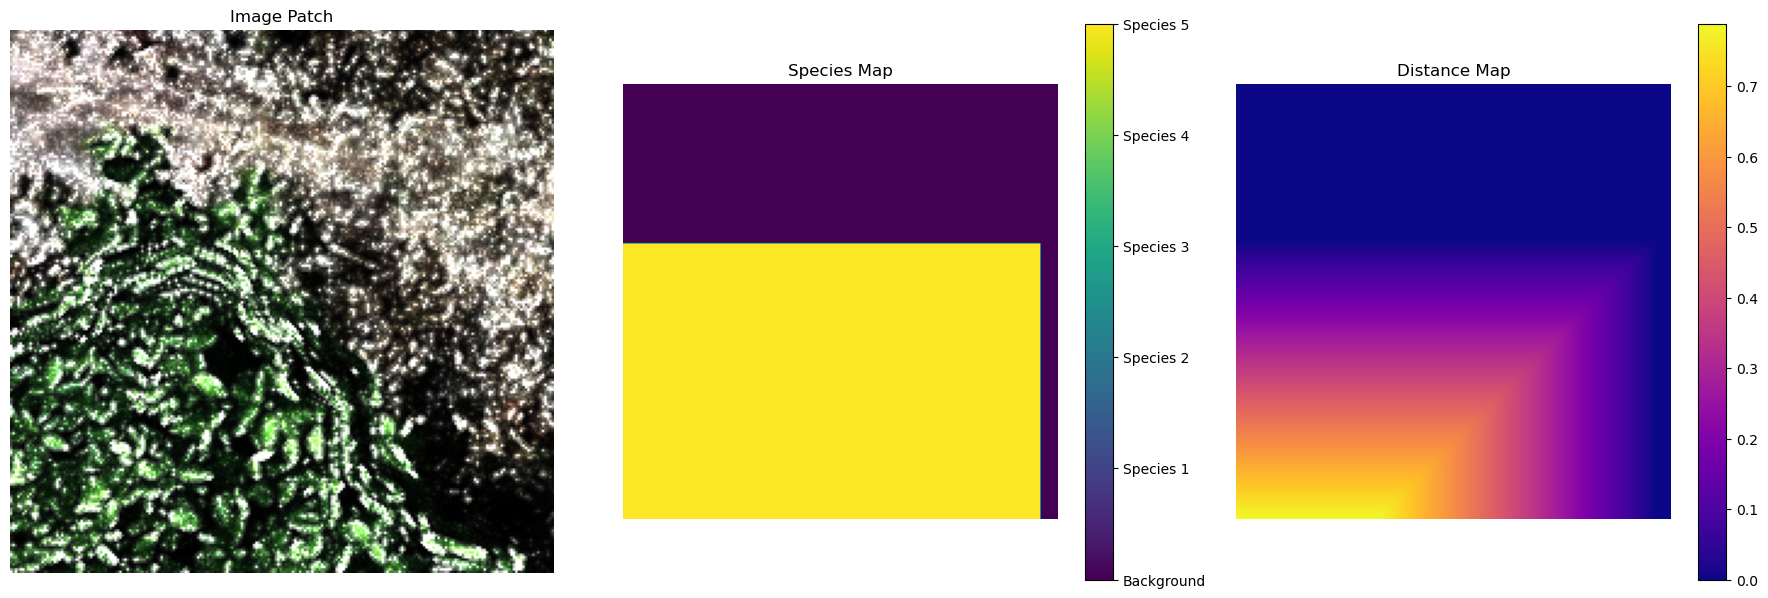

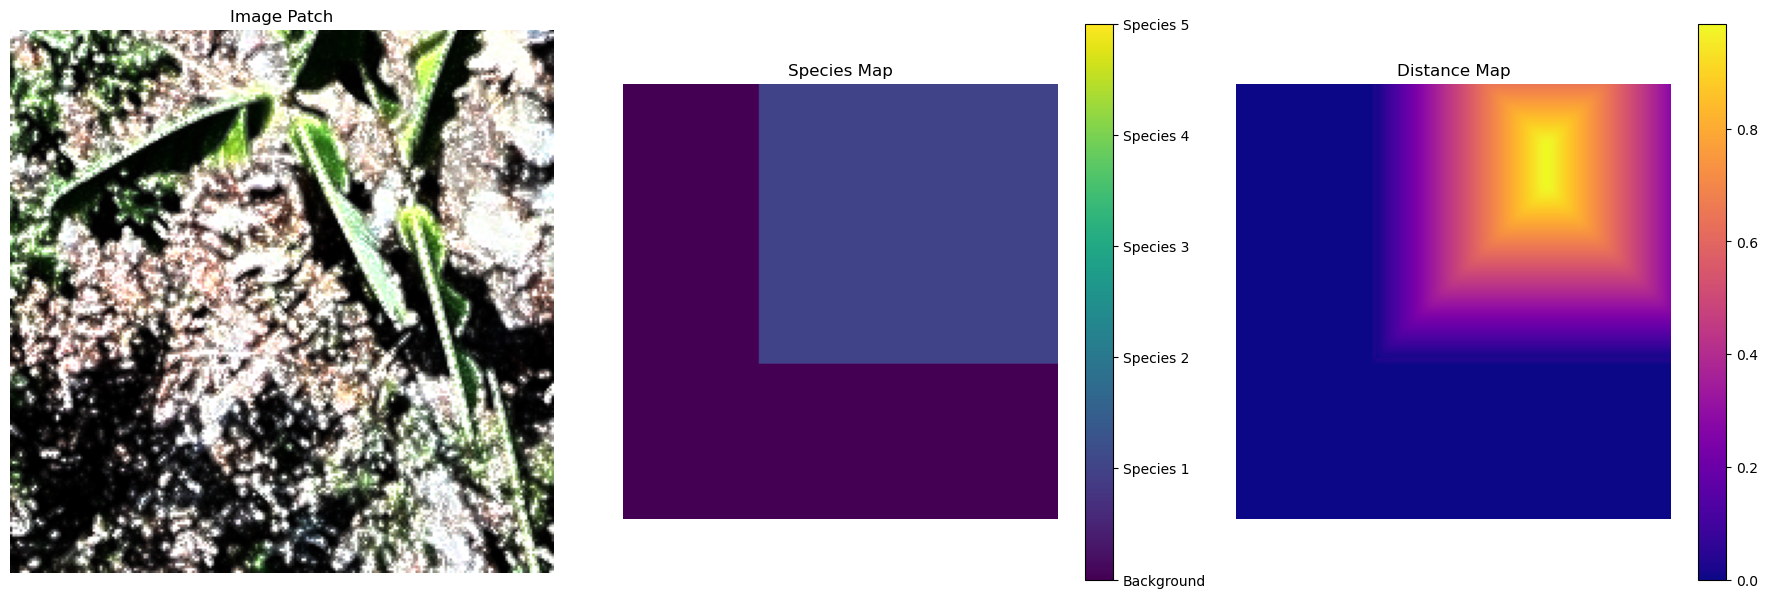

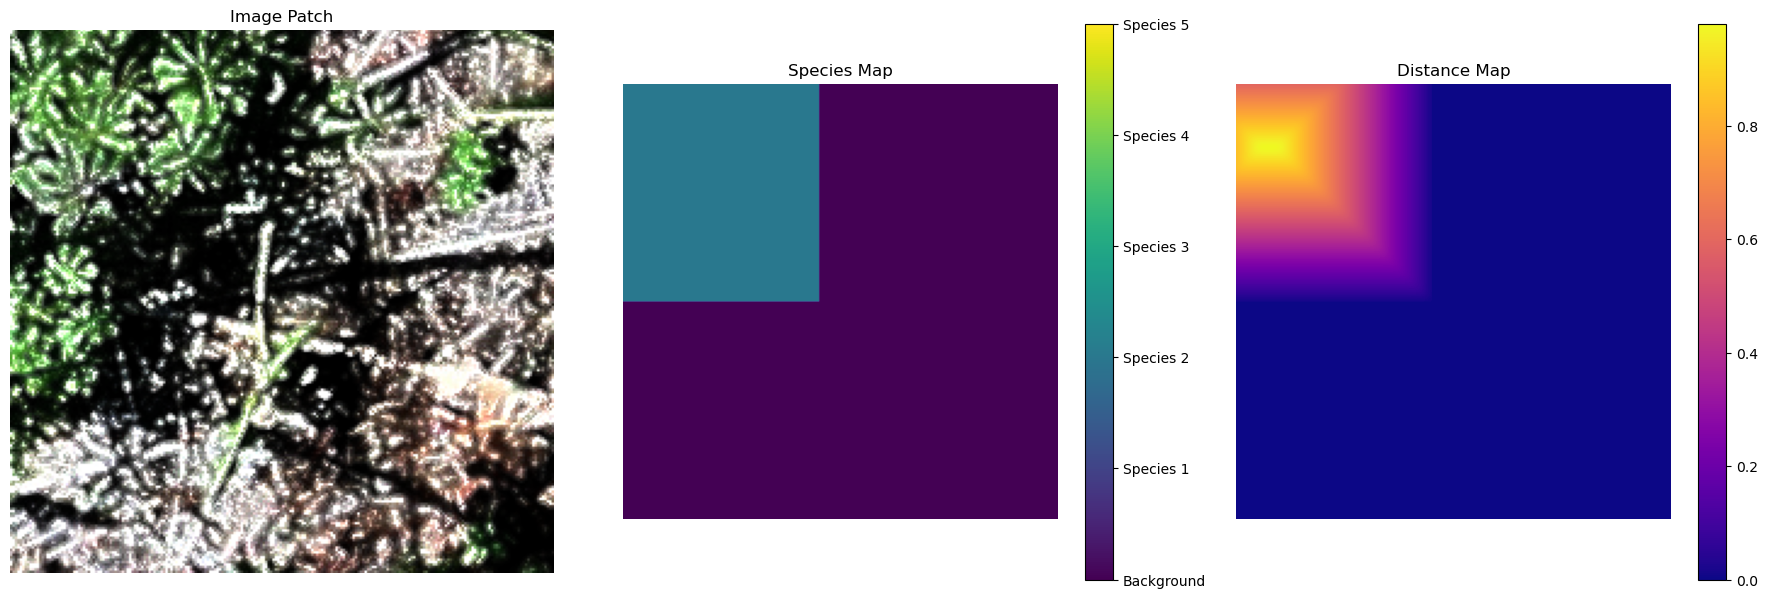

In [65]:
#visualize some of the patches 
mu.visualize_patches(data_iter)

## Testing Data Loaded Correctly 

In [66]:
val_data = mu.TreeCrownDataset(dataframe=val_df, root_dir=root_dir, transform=transform)

In [67]:
train_loader = DataLoader(train_data, batch_size=4, shuffle=False)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False)

Measuring how long it takes to load a training batch; because we are cropping on the fly, this doesn't happen instantaneously. 

In [68]:
start_time = time.time()

data_iter = iter(train_loader)
images, species, distance = next(data_iter)

end_time = time.time()
print(f"Time to process one batch: {end_time - start_time} seconds")

Time to process one batch: 30.945420742034912 seconds


And a val batch

In [69]:
start_time = time.time()

data_iter = iter(val_loader)
images, species, distance = next(data_iter)

end_time = time.time()
print(f"Time to process one batch: {end_time - start_time} seconds")

Time to process one batch: 24.152583837509155 seconds


### Making sure there are distinct classes

In [70]:
val_class_distribution = mu.analyze_class_distribution(val_loader)
print(val_class_distribution)

{0: 1370696, 1: 486235, 2: 50092, 3: 765981, 5: 136852}


### Test Dataset: Visualization to Confirm Proper Loading

In [71]:
test_data = mu.TestDataset(dataframe=test_df, root_dir=root_dir)

In [72]:
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)
test_iter = iter(test_loader)
images, species_maps, dist_maps = next(test_iter)

In [73]:
cmap, norm, legend_info = mu.set_visuals()

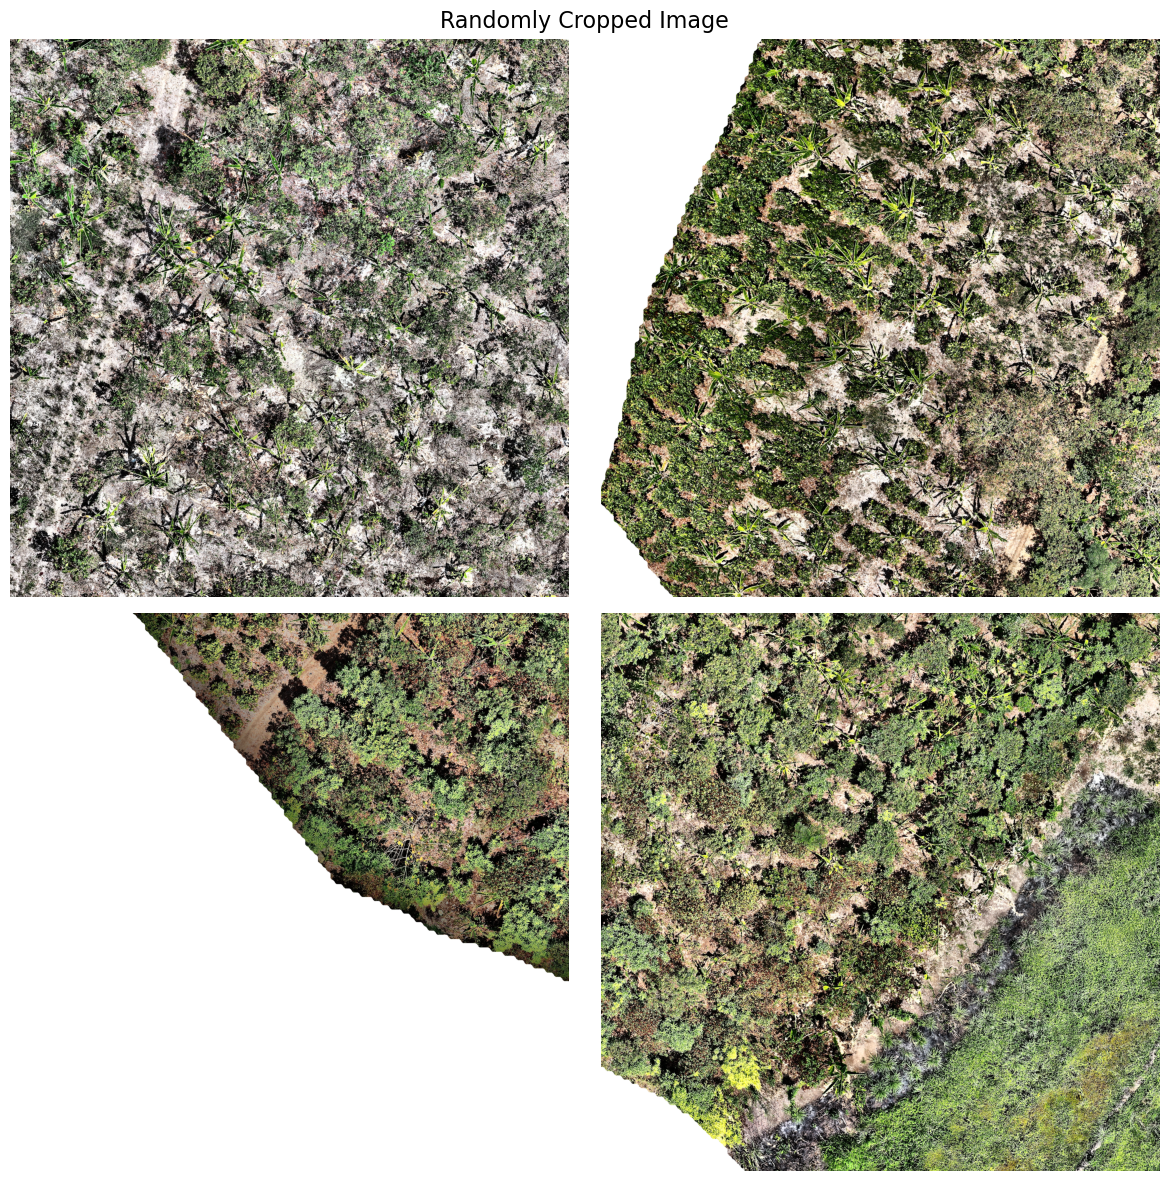

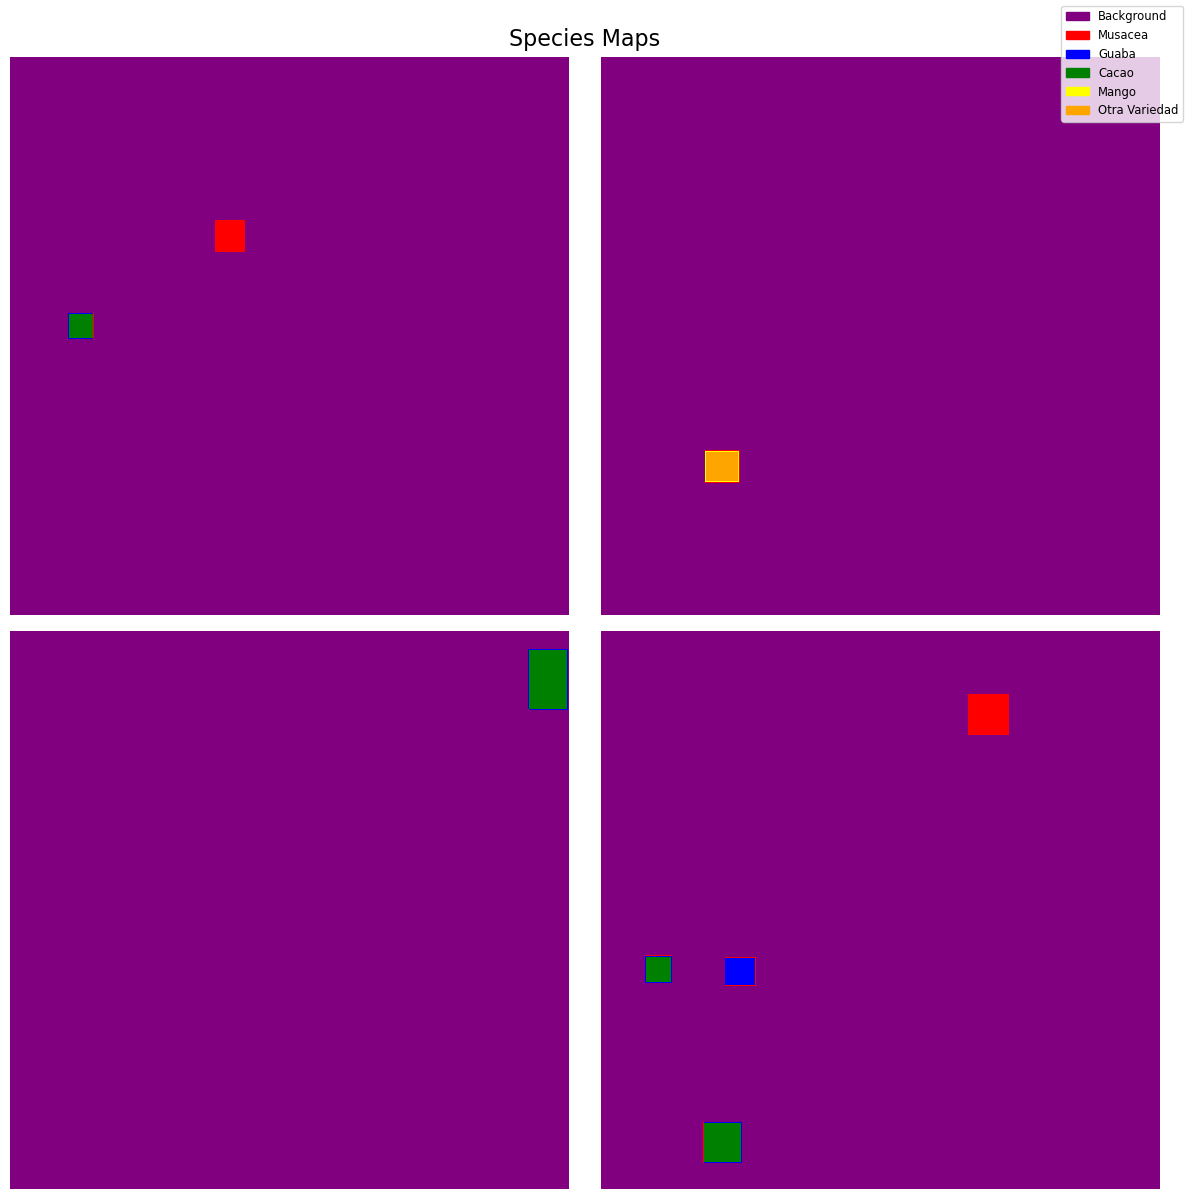

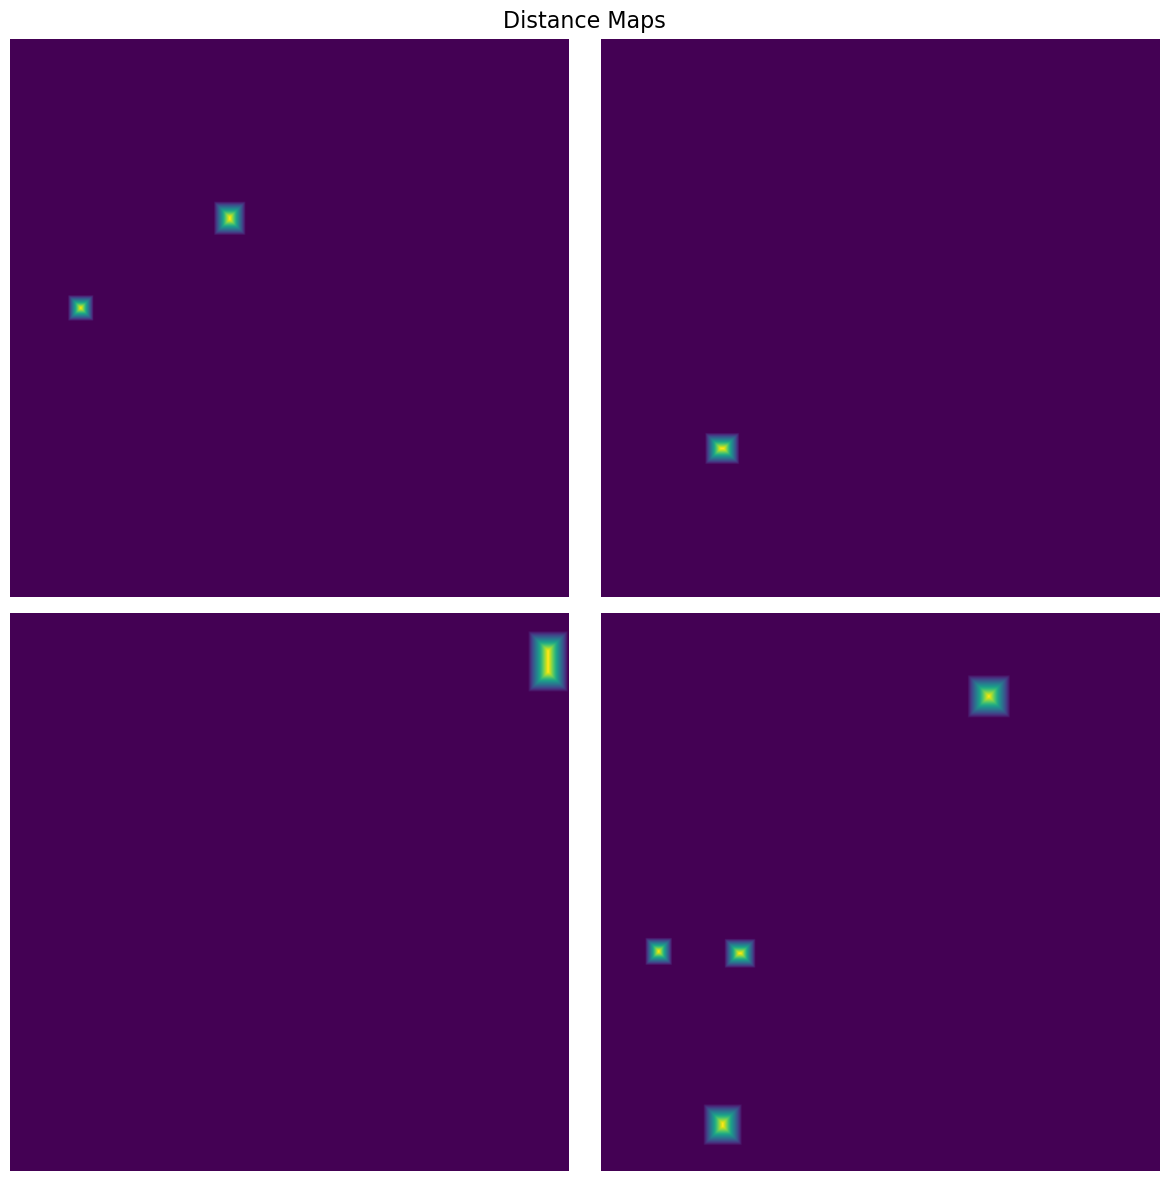

In [74]:
mu.show_images(images, title="Randomly Cropped Image")
mu.show_images_with_legend(species_maps,title="Species Maps", cmap=cmap, norm=norm, legend_patches=legend_info)
mu.show_images(dist_maps,title="Distance Maps")

______

# Running the Model

## Setting Device

In [75]:
device = mu.set_device("cuda")

No GPU available! Running on CPU


## Training the Model 

In [76]:
model = mu.SEDDModel(num_classes=6).to(device)
semantic_loss_fn = mu.PartiallyWeightedCategoricalFocalLoss(alpha=0.25).to(device)
distance_loss_fn = nn.MSELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 2

/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<Figure size 640x480 with 0 Axes>

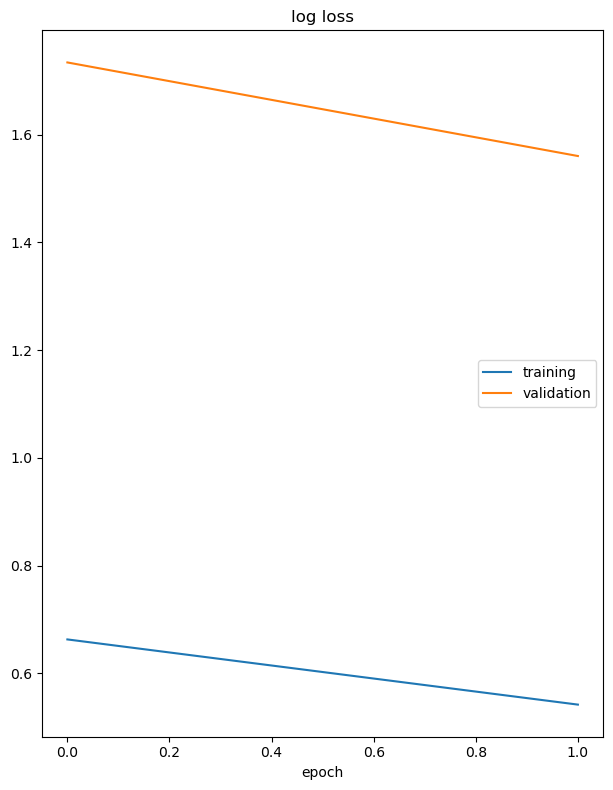

log loss
	training         	 (min:    0.542, max:    0.663, cur:    0.542)
	validation       	 (min:    1.560, max:    1.734, cur:    1.560)
Epoch [2/2], Train Loss: 0.5418, Validation Loss: 1.5605


<Figure size 640x480 with 0 Axes>

: 

In [83]:
liveplot = PlotLosses()

start = time.time()

for epoch in range(num_epochs):
    logs = {}
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # Fit the model and calculate training loss
    train_loss = mu.fit(model, train_loader, optimizer, semantic_loss_fn, distance_loss_fn, device)
    print(f'Fitting took {time.time()-start:.2f} seconds')

    # Validate the model and calculate validation loss
    val_loss = mu.validate(model, val_loader, semantic_loss_fn, distance_loss_fn, device)
    print(f'Validation took {time.time()-start:.2f} seconds')
    
    # Log the losses
    logs['log loss'] = train_loss
    logs['val_log loss'] = val_loss

    # Update and draw live plot
    liveplot.update(logs)
    liveplot.draw()

    # Step the learning rate scheduler
    scheduler.step()

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), "SEDD_final_small.pth")